# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 74.9 MB/s eta 0:00:00


In [2]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.base import clone
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from scipy.special import logit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import joblib 
import optuna
import json
import os
import gc

warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/ai-competition-africa/train.csv'
    test_path = '/kaggle/input/ai-competition-africa/test.csv'
    sample_sub_path = '/kaggle/input/ai-competition-africa/sample_submission.csv'
    original_data_path = '/kaggle/input/wine-quality-dataset/WineQT.csv'
    
    target = 'quality'
    n_folds = 10
    seed = 1807

# Loading and processing the dataset

In [4]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')
original = pd.read_csv(CFG.original_data_path, index_col='Id')

train[CFG.target] = train[CFG.target].astype(int)
original[CFG.target] = original[CFG.target].astype(int)

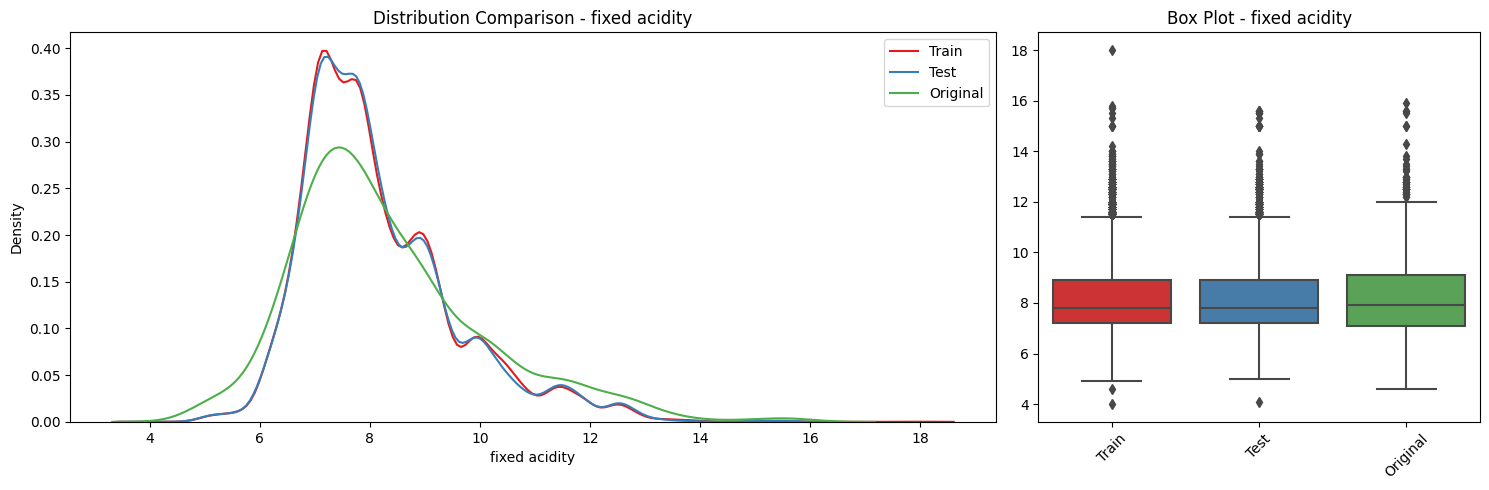

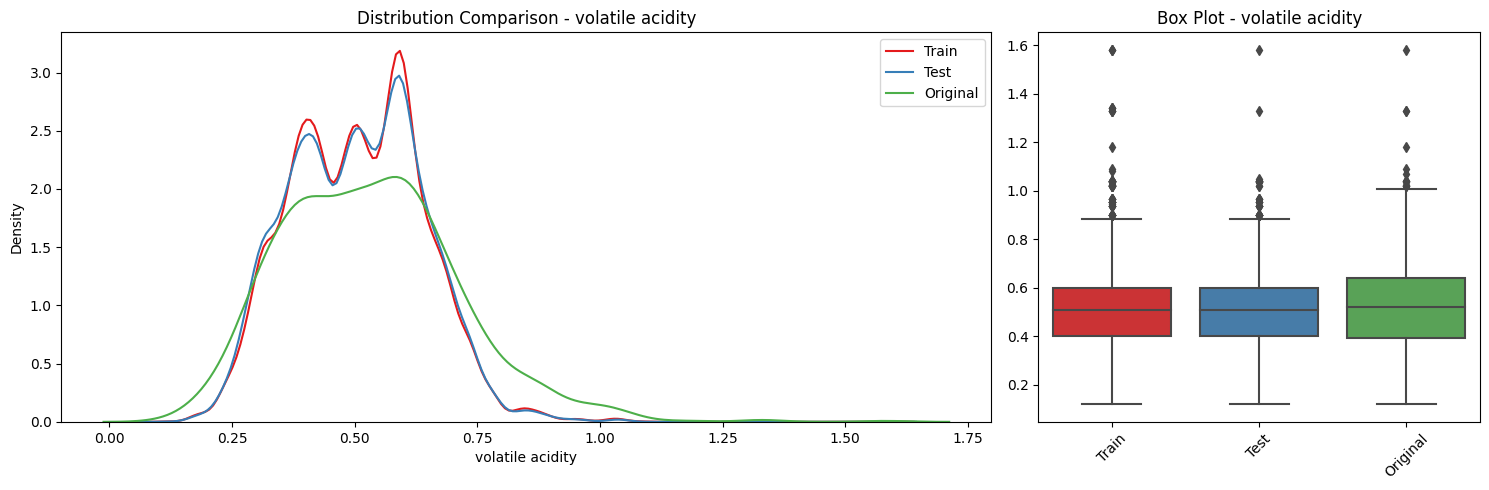

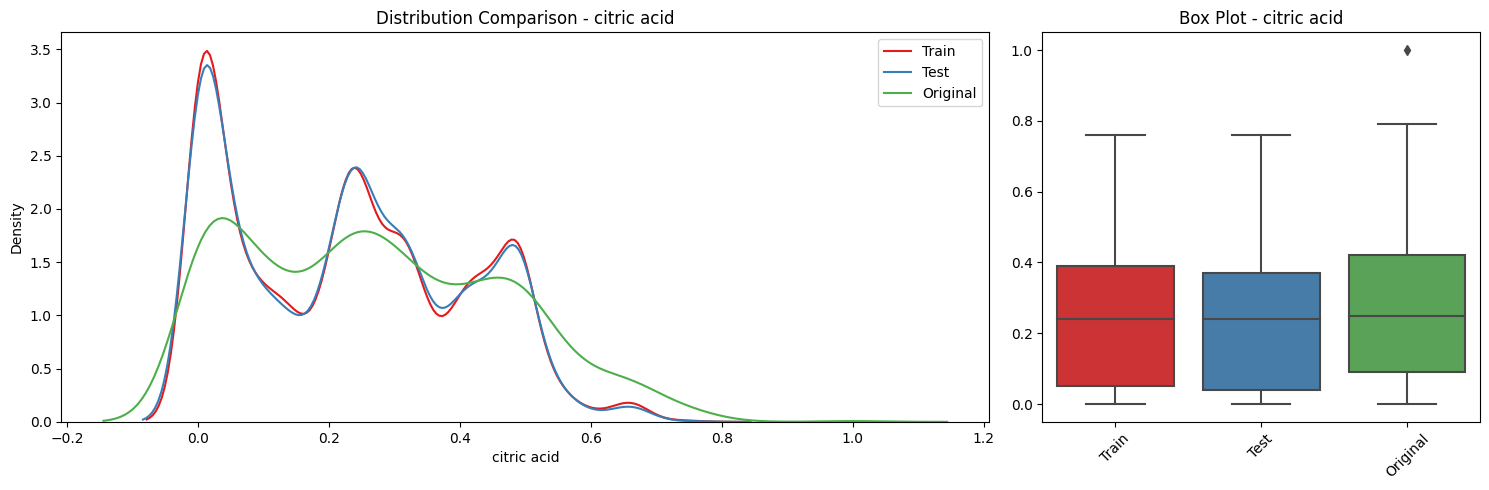

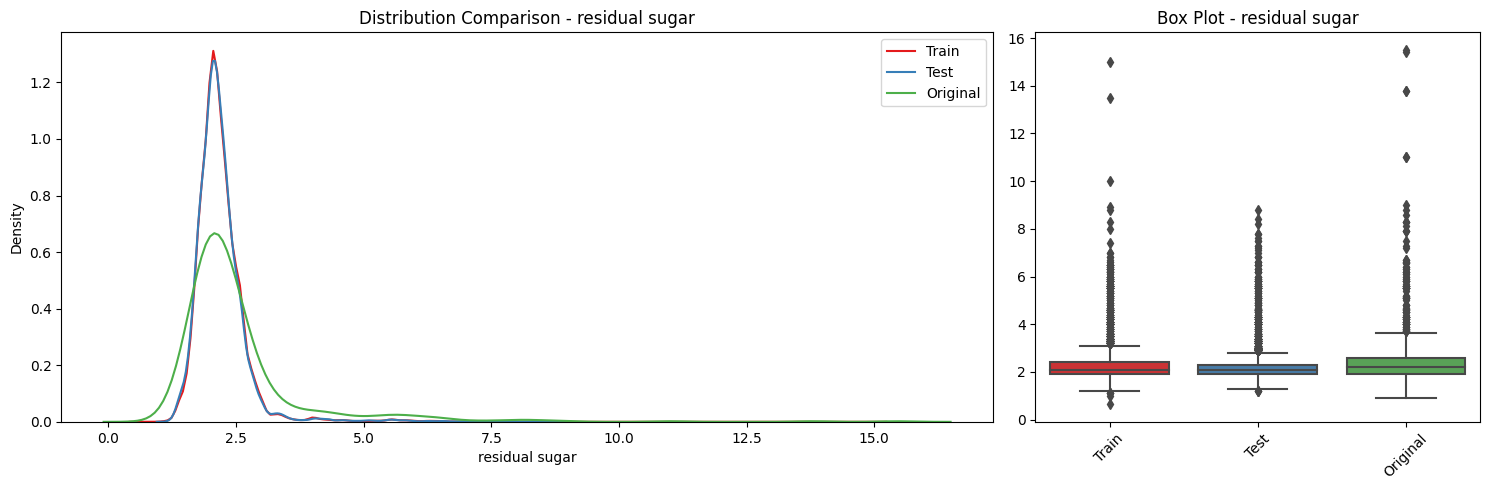

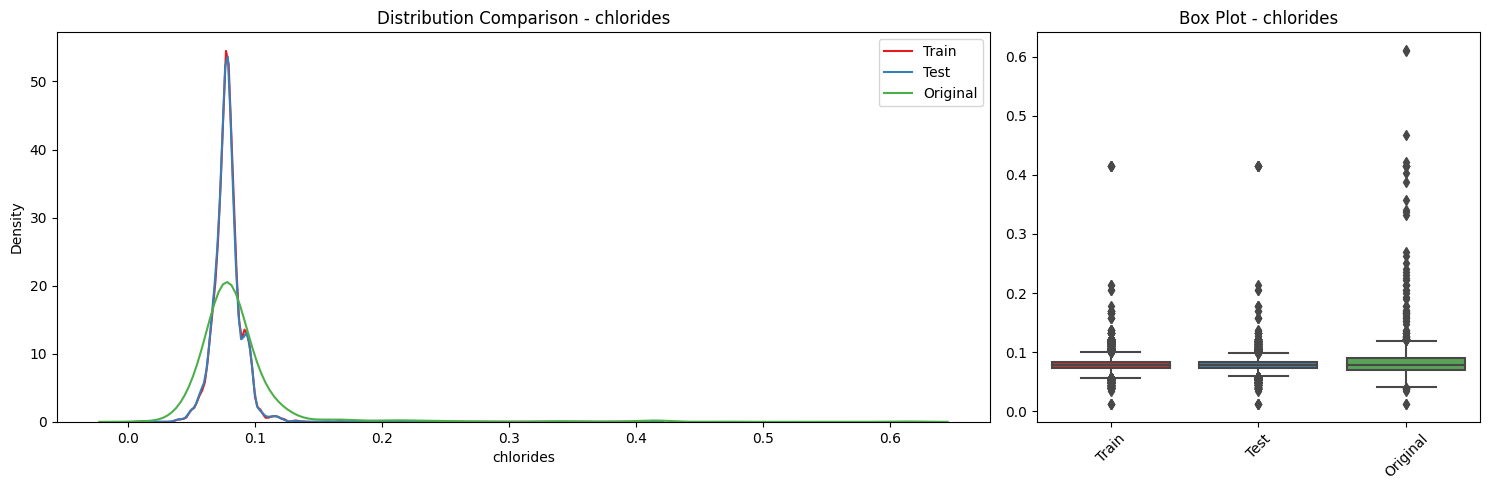

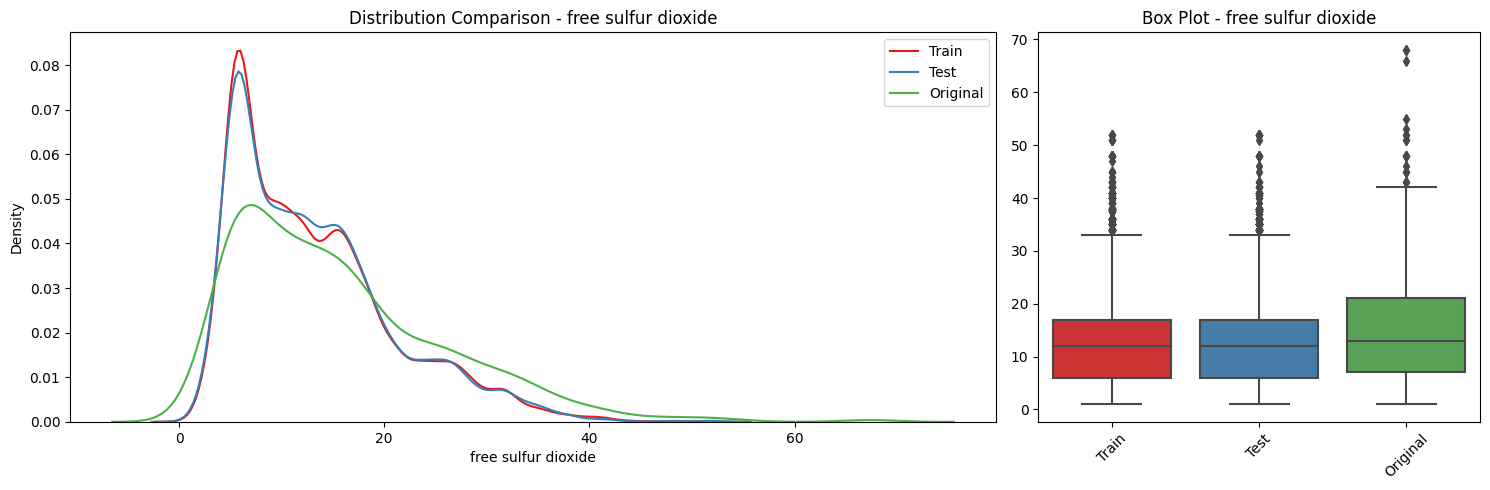

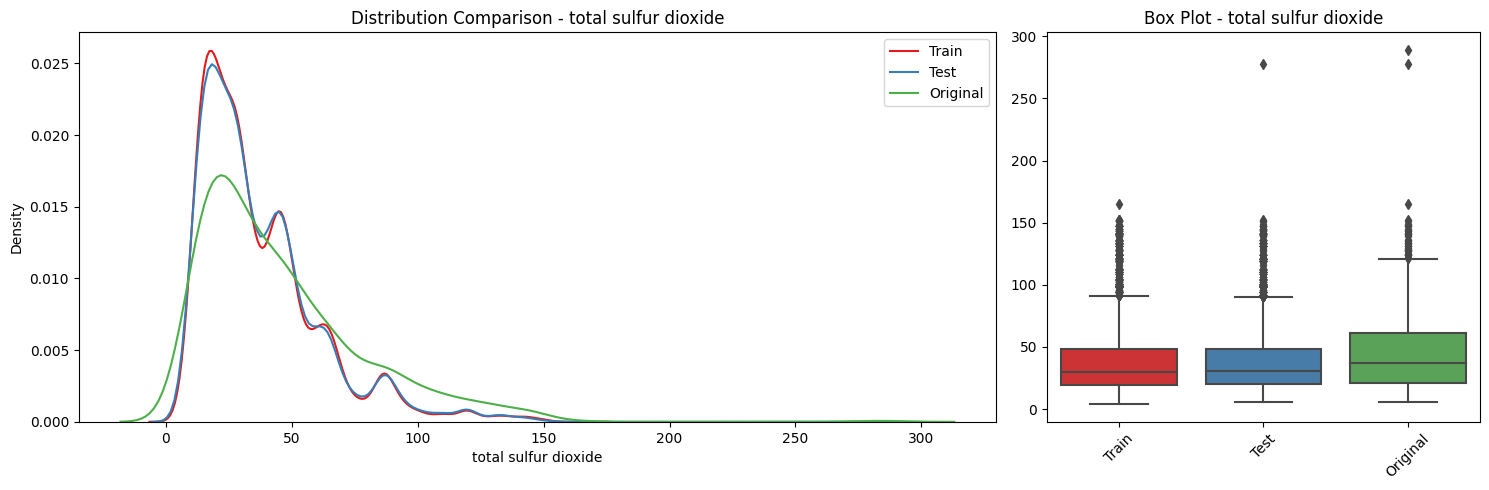

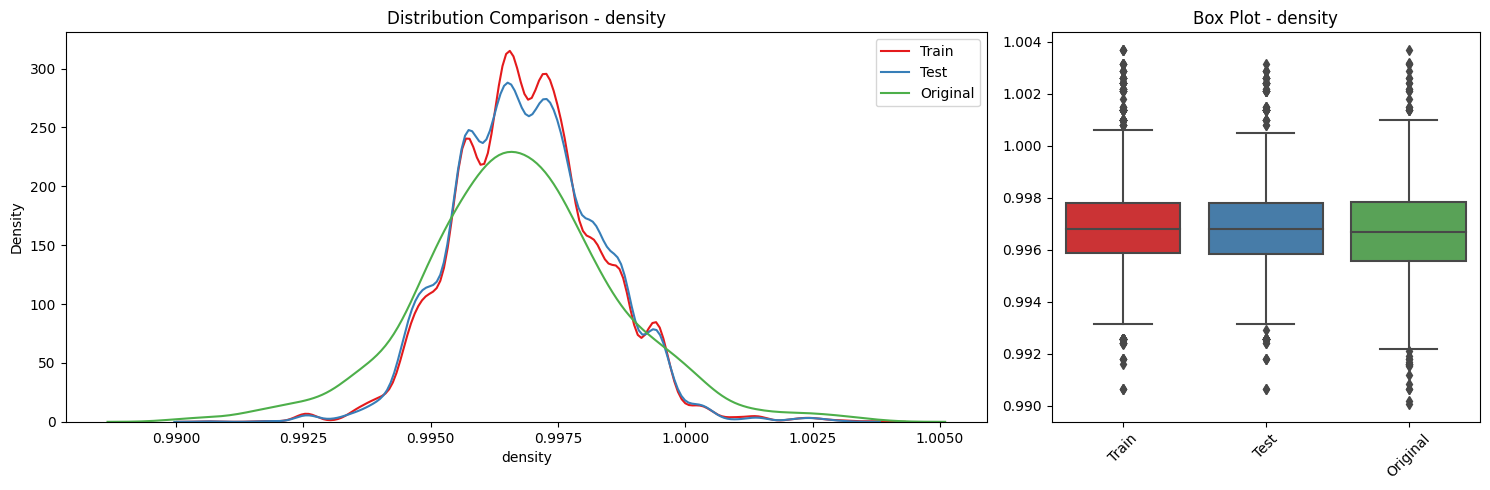

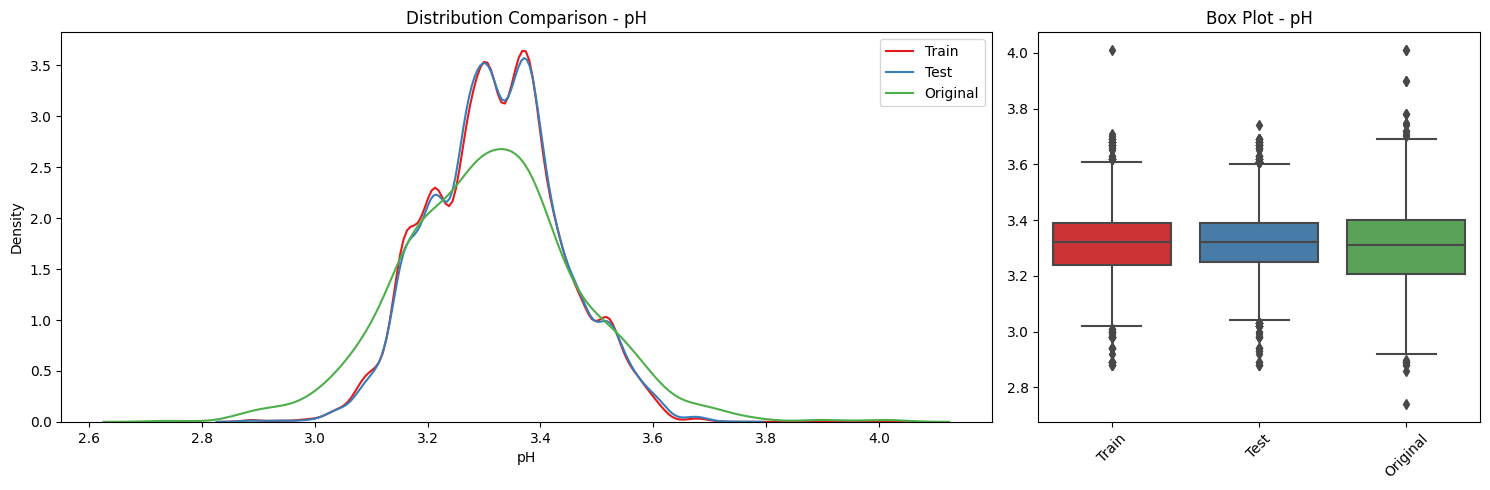

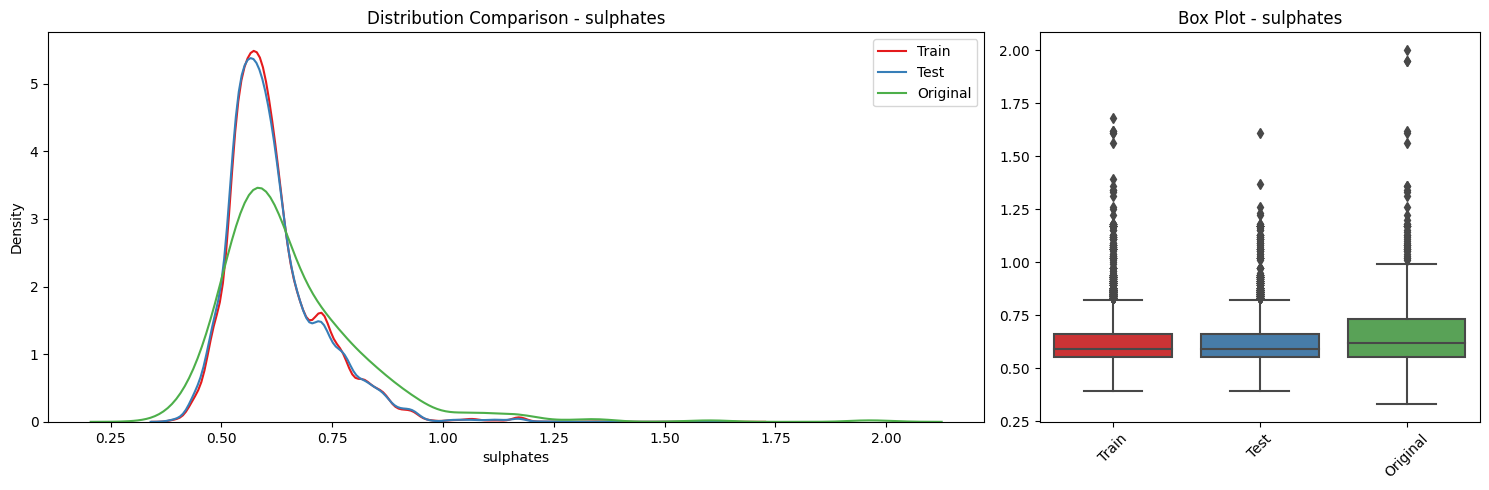

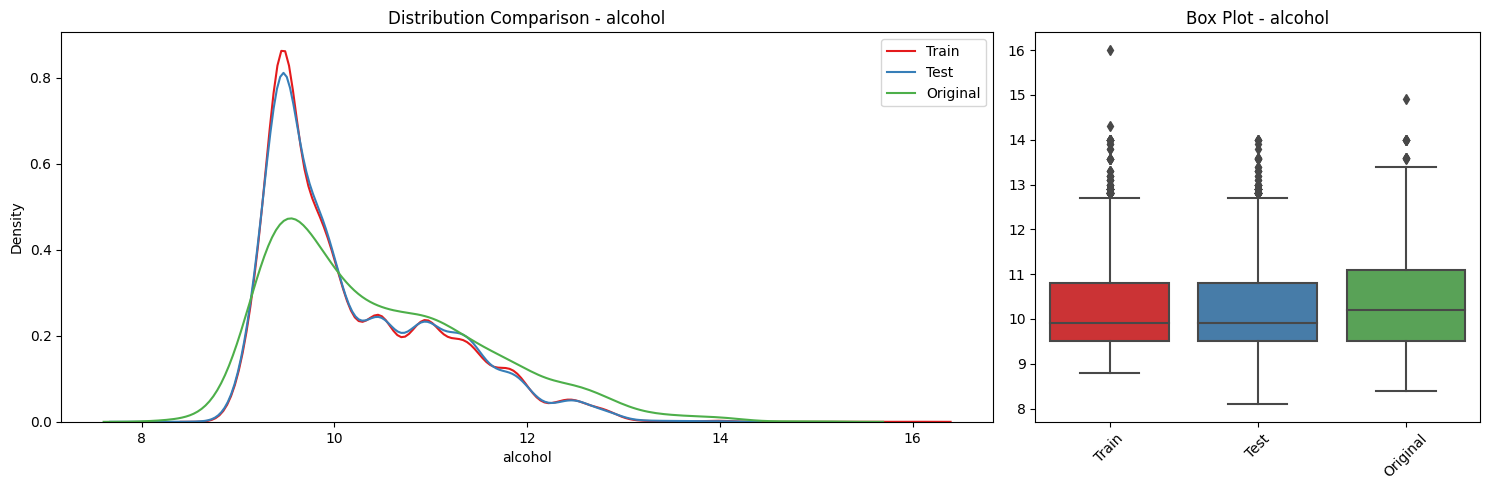

In [5]:
def plot_feature_distributions(train_df, original_df, test_df, feature):
    plt.figure(figsize=(15, 5))
    
    gs = plt.GridSpec(1, 3)
    plt.subplot(gs[0, :2])
    sns.kdeplot(data=train_df, x=feature, label='Train', color=sns.color_palette("Set1")[0])
    sns.kdeplot(data=test_df, x=feature, label='Test', color=sns.color_palette("Set1")[1])
    sns.kdeplot(data=original_df, x=feature, label='Original', color=sns.color_palette("Set1")[2])
    plt.title(f'Distribution Comparison - {feature}')
    plt.legend()
    
    plt.subplot(gs[0, 2])
    data_to_plot = pd.DataFrame({
        'Train': train_df[feature],
        'Test': test_df[feature],
        'Original': original_df[feature],
    })
    sns.boxplot(data=data_to_plot, palette='Set1')
    plt.title(f'Box Plot - {feature}')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

features = [col for col in train.columns if col != CFG.target]
for feature in features:
    plot_feature_distributions(train, original, test, feature)

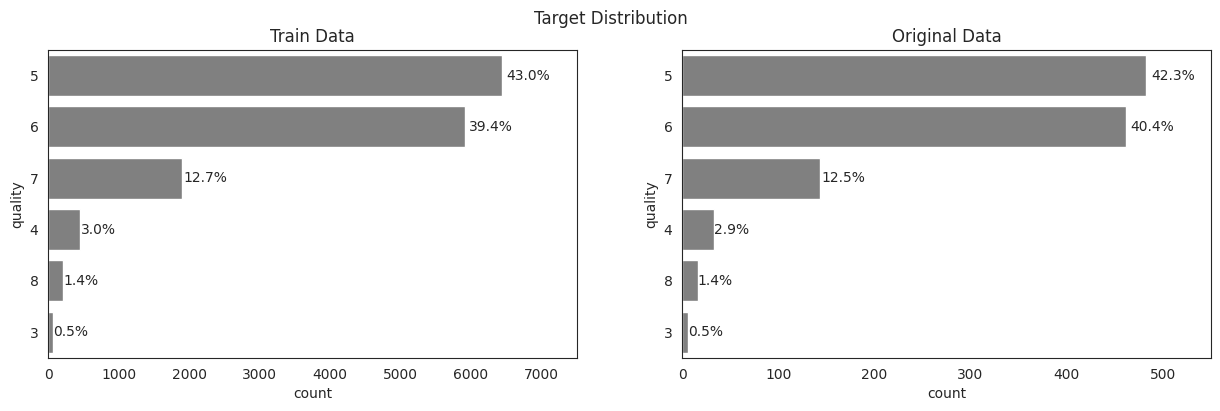

In [6]:
sns.set_style('white')
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

train_counts = train['quality'].value_counts()
original_counts = original['quality'].value_counts()

train_percentages = train_counts / train_counts.sum() * 100
original_percentages = original_counts / original_counts.sum() * 100

sns.countplot(data=train, y='quality', ax=ax[0], order=train_counts.index, color="grey")
for i, (count, percentage) in enumerate(zip(train_counts, train_percentages)):
    ax[0].text(count + count * 0.01, i, f'{percentage:.1f}%', va='center')
ax[0].set_title('Train Data')
ax[0].set_xlim(0, 7500)

sns.countplot(data=original, y='quality', ax=ax[1], order=original_counts.index, color="grey")
for i, (count, percentage) in enumerate(zip(original_counts, original_percentages)):
    ax[1].text(count + count * 0.01, i, f'{percentage:.1f}%', va='center')
ax[1].set_title('Original Data')
ax[1].set_xlim(0, 550)

plt.suptitle('Target Distribution')
plt.show()

In [7]:
from sklearn.feature_selection import mutual_info_classif

X_mi = train.drop(CFG.target, axis=1)
y_mi = train[CFG.target]

mutual_info = mutual_info_classif(X_mi, y_mi, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_mi.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
alcohol,0.132434
total sulfur dioxide,0.017037
density,0.011314
fixed acidity,0.008313
volatile acidity,0.005341
residual sugar,0.005338
free sulfur dioxide,0.004799
pH,0.002568
sulphates,0.002522
citric acid,0.001762


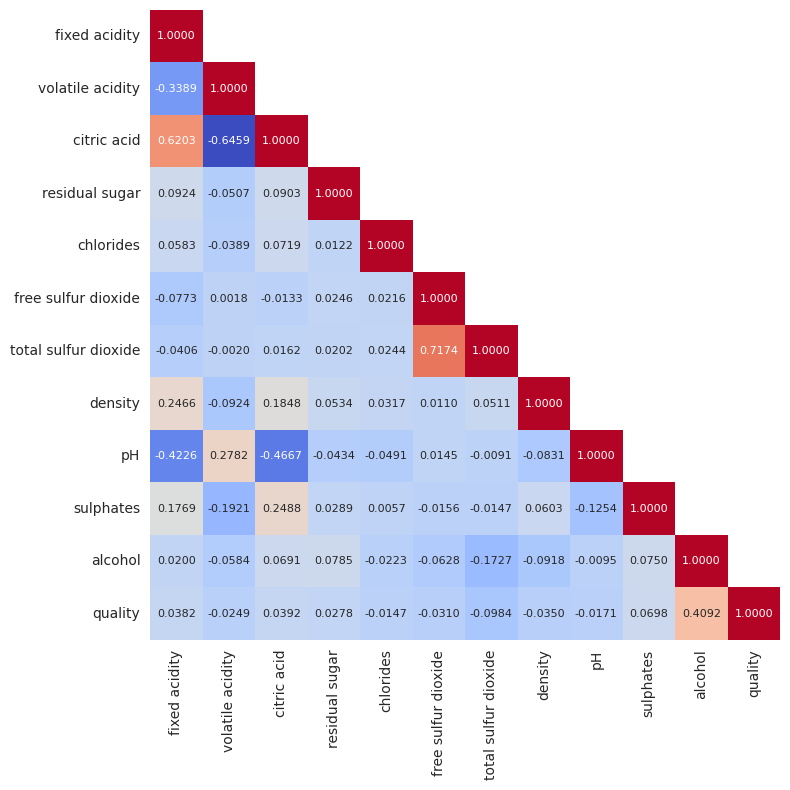

In [8]:
sns.set_style("white")
plt.figure(figsize=(8, 8))

corr_train = pd.concat([X_mi, y_mi], axis=1).corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.4f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 8},
    cbar=False
)

plt.tight_layout()
plt.show()

In [9]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')
original = pd.read_csv(CFG.original_data_path, index_col='Id')

train[CFG.target] = train[CFG.target].astype(int)
original[CFG.target] = original[CFG.target].astype(int)

mapping = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5}
train[CFG.target] = train[CFG.target].map(mapping)
original[CFG.target] = original[CFG.target].map(mapping)

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

X_original = original.drop(CFG.target, axis=1)
y_original = original[CFG.target]

In [10]:
classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict

{0: 33.333333333333336,
 1: 5.506607929515418,
 2: 0.3880180040353872,
 3: 0.42265426880811496,
 4: 1.3144058885383807,
 5: 11.848341232227488}

# Training base models

In [11]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test, X_original=None, y_original=None):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
                                          
            if X_original is not None and y_original is not None:
                X_train = pd.concat([X_train, X_original], ignore_index=True)
                y_train = pd.concat([y_train, y_original], ignore_index=True)
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = cohen_kappa_score(y_val, np.argmax(y_pred_probs, axis=1), weights='quadratic')
            scores.append(score)
            
            if isinstance(self.model, LogisticRegression):
                n_iters = model.n_iter_[0]
                print(f'--- Fold {fold_idx + 1} - QWK: {score:.6f} ({n_iters} iterations)')
            else:
                print(f'--- Fold {fold_idx + 1} - QWK: {score:.6f}')
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        overall_score = cohen_kappa_score(y, np.argmax(oof_pred_probs, axis=1), weights='quadratic')
            
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
        
        if isinstance(self.model, LogisticRegression):
            return oof_pred_probs, test_pred_probs, scores
        else:
            os.makedirs('oof_pred_probs', exist_ok=True)
            os.makedirs('test_pred_probs', exist_ok=True)
            self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
            self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
            return oof_pred_probs, test_pred_probs, scores
    
    def tune(self, X, y):               
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs 
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return cohen_kappa_score(y, np.argmax(oof_pred_probs, axis=1), weights='quadratic')       
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        joblib.dump(pred_probs, f'{name}_pred_probs/{model_name}_{name}_pred_probs_{cv_score:.6f}.pkl')

In [12]:
def save_submission(name, test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = np.argmax(test_pred_probs, axis=1)
    sub[CFG.target] = sub[CFG.target].map({0: 3, 1: 4, 2: 5, 3: 6, 4: 7, 5: 8})
    sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)
    return sub

In [13]:
xgb_params = {
    'n_jobs': -1,
    'random_state': CFG.seed,
    'verbosity': 0,
    'class_weight': class_weight_dict
}

lgbm_params = {
    'boosting_type': "gbdt",
    'random_state': CFG.seed,
    'n_jobs': -1,
    'verbose': -1,
    'class_weight': class_weight_dict
}

lgbm_goss_params = {
    'random_state': CFG.seed,
    'n_jobs': -1,
    'verbosity': -1,
    'boosting_type': 'goss',
    'class_weight': class_weight_dict
}

cb_params = {
    'random_state': CFG.seed,
    'verbose': False,
    'class_weights': class_weights
}

hgb_params = {
    'random_state': CFG.seed,
    'class_weight': class_weight_dict
}

gb_params = {
    'random_state': CFG.seed
}

rf_params = {
    'random_state': CFG.seed,
    'n_jobs': -1,
    'class_weight': class_weight_dict
}

adb_params = {
    'random_state': CFG.seed
}

et_params = {
    'random_state': CFG.seed,
    'n_jobs': -1,
    'class_weight': class_weight_dict
}

In [14]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

## XGBoost

In [15]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_pred_probs['XGBoost'], test_pred_probs['XGBoost'], scores['XGBoost'] = xgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training XGBClassifier

--- Fold 1 - QWK: 0.306657
--- Fold 2 - QWK: 0.326049
--- Fold 3 - QWK: 0.324304
--- Fold 4 - QWK: 0.342546
--- Fold 5 - QWK: 0.358829
--- Fold 6 - QWK: 0.350939
--- Fold 7 - QWK: 0.393979
--- Fold 8 - QWK: 0.341361
--- Fold 9 - QWK: 0.367813
--- Fold 10 - QWK: 0.346101

------ Overall: 0.346017 | Average: 0.345858 ± 0.023273


## LightGBM

In [16]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_pred_probs['LightGBM'], test_pred_probs['LightGBM'], scores['LightGBM'] = lgbm_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

--- Fold 1 - QWK: 0.330503
--- Fold 2 - QWK: 0.323380
--- Fold 3 - QWK: 0.335309
--- Fold 4 - QWK: 0.363332
--- Fold 5 - QWK: 0.370121
--- Fold 6 - QWK: 0.342296
--- Fold 7 - QWK: 0.380920
--- Fold 8 - QWK: 0.371346
--- Fold 9 - QWK: 0.356369
--- Fold 10 - QWK: 0.354601

------ Overall: 0.352708 | Average: 0.352818 ± 0.018277


## LightGBM (goss)

In [17]:
lgbm_goss_model = LGBMClassifier(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_pred_probs['LightGBM (goss)'], test_pred_probs['LightGBM (goss)'], scores['LightGBM (goss)'] = lgbm_goss_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

--- Fold 1 - QWK: 0.337915
--- Fold 2 - QWK: 0.323547
--- Fold 3 - QWK: 0.325672
--- Fold 4 - QWK: 0.354644
--- Fold 5 - QWK: 0.320842
--- Fold 6 - QWK: 0.303028
--- Fold 7 - QWK: 0.327154
--- Fold 8 - QWK: 0.314246
--- Fold 9 - QWK: 0.366181
--- Fold 10 - QWK: 0.319521

------ Overall: 0.329245 | Average: 0.329275 ± 0.017921


## CatBoost

In [18]:
cb_model = CatBoostClassifier(**cb_params)
cb_trainer = Trainer(cb_model)
oof_pred_probs['CatBoost'], test_pred_probs['CatBoost'], scores['CatBoost'] = cb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training CatBoostClassifier

--- Fold 1 - QWK: 0.343395
--- Fold 2 - QWK: 0.351604
--- Fold 3 - QWK: 0.359068
--- Fold 4 - QWK: 0.374673
--- Fold 5 - QWK: 0.382643
--- Fold 6 - QWK: 0.358549
--- Fold 7 - QWK: 0.371712
--- Fold 8 - QWK: 0.402461
--- Fold 9 - QWK: 0.389442
--- Fold 10 - QWK: 0.377432

------ Overall: 0.371018 | Average: 0.371098 ± 0.017194


## HistGradientBoosting

In [19]:
hgb_model = HistGradientBoostingClassifier(**hgb_params)
hgb_trainer = Trainer(hgb_model)
oof_pred_probs['HistGradientBoosting'], test_pred_probs['HistGradientBoosting'], scores['HistGradientBoosting'] = hgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training HistGradientBoostingClassifier

--- Fold 1 - QWK: 0.305142
--- Fold 2 - QWK: 0.248094
--- Fold 3 - QWK: 0.271059
--- Fold 4 - QWK: 0.296133
--- Fold 5 - QWK: 0.319790
--- Fold 6 - QWK: 0.267403
--- Fold 7 - QWK: 0.289300
--- Fold 8 - QWK: 0.310881
--- Fold 9 - QWK: 0.305721
--- Fold 10 - QWK: 0.292006

------ Overall: 0.289990 | Average: 0.290553 ± 0.021129


## GradientBoosting

In [20]:
gb_model = GradientBoostingClassifier(**gb_params)
gb_trainer = Trainer(gb_model)
oof_pred_probs['GradientBoosting'], test_pred_probs['GradientBoosting'], scores['GradientBoosting'] = gb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training GradientBoostingClassifier

--- Fold 1 - QWK: 0.356314
--- Fold 2 - QWK: 0.373985
--- Fold 3 - QWK: 0.349369
--- Fold 4 - QWK: 0.388791
--- Fold 5 - QWK: 0.382872
--- Fold 6 - QWK: 0.374232
--- Fold 7 - QWK: 0.407626
--- Fold 8 - QWK: 0.379442
--- Fold 9 - QWK: 0.394070
--- Fold 10 - QWK: 0.363885

------ Overall: 0.377148 | Average: 0.377059 ± 0.016700


## RandomForest

In [21]:
rf_model = RandomForestClassifier(**rf_params)
rf_trainer = Trainer(rf_model)
oof_pred_probs['RandomForest'], test_pred_probs['RandomForest'], scores['RandomForest'] = rf_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training RandomForestClassifier

--- Fold 1 - QWK: 0.338591
--- Fold 2 - QWK: 0.323907
--- Fold 3 - QWK: 0.315988
--- Fold 4 - QWK: 0.346672
--- Fold 5 - QWK: 0.380154
--- Fold 6 - QWK: 0.352941
--- Fold 7 - QWK: 0.362899
--- Fold 8 - QWK: 0.353941
--- Fold 9 - QWK: 0.335004
--- Fold 10 - QWK: 0.327380

------ Overall: 0.343821 | Average: 0.343748 ± 0.018505


## AdaBoost

In [22]:
adb_model = AdaBoostClassifier(**adb_params)
adb_trainer = Trainer(adb_model)
oof_pred_probs['AdaBoost'], test_pred_probs['AdaBoost'], scores['AdaBoost'] = adb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training AdaBoostClassifier

--- Fold 1 - QWK: 0.346076
--- Fold 2 - QWK: 0.353576
--- Fold 3 - QWK: 0.328124
--- Fold 4 - QWK: 0.373080
--- Fold 5 - QWK: 0.366832
--- Fold 6 - QWK: 0.376804
--- Fold 7 - QWK: 0.409428
--- Fold 8 - QWK: 0.369687
--- Fold 9 - QWK: 0.377611
--- Fold 10 - QWK: 0.359375

------ Overall: 0.366036 | Average: 0.366059 ± 0.020571


## ExtraTrees

In [23]:
et_model = ExtraTreesClassifier(**et_params)
et_trainer = Trainer(et_model)
oof_pred_probs['ExtraTrees'], test_pred_probs['ExtraTrees'], scores['ExtraTrees'] = et_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training ExtraTreesClassifier

--- Fold 1 - QWK: 0.302794
--- Fold 2 - QWK: 0.341086
--- Fold 3 - QWK: 0.307636
--- Fold 4 - QWK: 0.347117
--- Fold 5 - QWK: 0.368095
--- Fold 6 - QWK: 0.306178
--- Fold 7 - QWK: 0.375922
--- Fold 8 - QWK: 0.334813
--- Fold 9 - QWK: 0.336529
--- Fold 10 - QWK: 0.331080

------ Overall: 0.335179 | Average: 0.335125 ± 0.023639


# Ensembling with Logistic Regression

In [24]:
temp_X = pd.DataFrame()
temp_X_test = pd.DataFrame()

for model, pred_probs in oof_pred_probs.items():
    for i in range(pred_probs.shape[1]):
        temp_X[f'{model}_{i}'] = pred_probs[:, i]

for model, pred_probs in test_pred_probs.items():
    for i in range(pred_probs.shape[1]):
        temp_X_test[f'{model}_{i}'] = pred_probs[:, i]

X = logit(temp_X.clip(1e-15, 1-1e-15))
X_test = logit(temp_X_test.clip(1e-15, 1-1e-15))

In [25]:
# def objective(trial):
#     solver_penalty_options = [
#         ('liblinear', 'l1'),
#         ('liblinear', 'l2'),
#         ('lbfgs', 'l2'),
#         ('lbfgs', None),
#         ('newton-cg', 'l2'),
#         ('newton-cg', None),
#         ('newton-cholesky', 'l2'),
#         ('newton-cholesky', None)
#     ]
#     solver, penalty = trial.suggest_categorical('solver_penalty', solver_penalty_options)
    
#     params = {
#         'random_state': CFG.seed,
#         'class_weight': class_weight_dict,
#         'max_iter': trial.suggest_int('max_iter', 100, 2500, step=100),
#         'C': trial.suggest_float('C', 0, 10),
#         'tol': trial.suggest_float('tol', 1e-5, 1e-2),
#         'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
#         'solver': solver,
#         'penalty': penalty
#     }
    
#     model = LogisticRegression(**params)
#     trainer = Trainer(model)
#     return trainer.tune(X, y)

# sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
# study = optuna.create_study(direction='maximize', sampler=sampler)
# study.optimize(objective, n_trials=50, n_jobs=-1)
# best_params = study.best_params

In [26]:
# solver, penalty = best_params['solver_penalty']
lr_params = {
    'random_state': CFG.seed,
    'class_weight': class_weight_dict,
    # 'max_iter': best_params['max_iter'],
    # 'C': best_params['C'],
    # 'tol': best_params['tol'],
    # 'fit_intercept': best_params['fit_intercept'],
    # 'solver': solver,
    # 'penalty': penalty
}

In [27]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model)
lr_oof_pred_probs, lr_test_pred_probs, scores['LR Ensemble'] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - QWK: 0.228914 (100 iterations)
--- Fold 2 - QWK: 0.209121 (100 iterations)
--- Fold 3 - QWK: 0.221914 (100 iterations)
--- Fold 4 - QWK: 0.228883 (100 iterations)
--- Fold 5 - QWK: 0.210291 (100 iterations)
--- Fold 6 - QWK: 0.203688 (100 iterations)
--- Fold 7 - QWK: 0.215413 (100 iterations)
--- Fold 8 - QWK: 0.226069 (100 iterations)
--- Fold 9 - QWK: 0.180974 (100 iterations)
--- Fold 10 - QWK: 0.230252 (100 iterations)

------ Overall: 0.215135 | Average: 0.215552 ± 0.014591


In [28]:
save_submission('lr-ensemble', lr_test_pred_probs, np.mean(scores['LR Ensemble'])).head()

,id,quality
0,15000,5
1,15001,5
2,15002,8
3,15003,8
4,15004,5


# Results

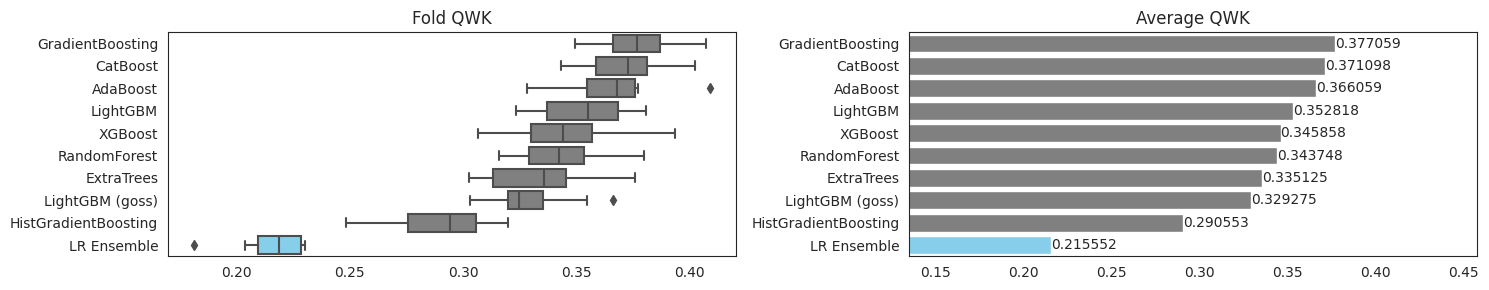

In [29]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', color='grey')
axs[0].set_title('Fold QWK')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color='grey')
axs[1].set_title('Average QWK')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = 'skyblue' if 'ensemble' in model.lower() else 'grey'
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

In [30]:
shutil.rmtree('catboost_info', ignore_errors=True)